# Основы машинного обучения, ПАДиИИ

## НИУ ВШЭ, 2024-25 учебный год

# Домашнее задание 5: Древесные алгоритмы

Задание выполнил(а):

    Демьянов Степан

## Общая информация

__Внимание!__  


* Домашнее задание выполняется самостоятельно
* Не допускается помощь в решении домашнего задания от однокурсников или третьих лиц. «Похожие» решения считаются плагиатом, и все задействованные студенты — в том числе и те, у кого списали, — не могут получить за него больше 0 баллов
* Использование в решении домашнего задания генеративных моделей (ChatGPT и так далее) за рамками справочной и образовательной информации для генерации кода задания — считается плагиатом, и такое домашнее задание оценивается в 0 баллов
* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
import numpy as np
p_k1 = 0.8
p_k2 = 0.2
entropy = - (p_k1 * np.log(p_k1) + p_k2 * np.log(p_k2))
print(f"Энтропия: {entropy:.2f}")

Энтропия: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def gini_impurity(counts):
    total = sum(counts)
    if total == 0:
        return 0
    impurity = 0
    for c in counts:
        p = c / total
        impurity += p * (1 - p)
    return impurity

Rm_counts = [8, 2]
H_Rm = gini_impurity(Rm_counts)
H_left = gini_impurity([8, 0])
H_right = gini_impurity([0, 2])
Q = H_Rm - (8/10)*H_left - (2/10)*H_right
print(f"Информационный прирост Q: {Q:.2f}")


Информационный прирост Q: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
prediction = np.mean(values)
print(f"Среднее значение: {prediction:.2f}")

Среднее значение: 40.60


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы.


**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector = np.array(feature_vector).flatten()
    target_vector = np.array(target_vector).flatten()

    if feature_type == "real":
        vals = np.sort(np.unique(feature_vector))
        thresholds = (vals[:-1] + vals[1:]) / 2
    elif feature_type == "categorical":
        thresholds = np.unique(feature_vector)
    else:
        raise ValueError("Unknown feature_type")

    if task == "classification":
        classes, counts = np.unique(target_vector, return_counts=True)
        p = counts / counts.sum()
        H_parent = np.sum(p * (1 - p))
    else:
        H_parent = np.var(target_vector)

    best_gain = -np.inf
    best_thr = None
    gains = []

    for thr in thresholds:
        if feature_type == "real":
            left_mask = feature_vector <= thr
        else:
            left_mask = feature_vector == thr
        right_mask = ~left_mask

        if not np.any(left_mask) or not np.any(right_mask):
            gains.append(-np.inf)
            continue

        y_left = target_vector[left_mask]
        y_right = target_vector[right_mask]

        if task == "classification":
            _, cnt_l = np.unique(y_left, return_counts=True)
            _, cnt_r = np.unique(y_right, return_counts=True)
            p_l = cnt_l / cnt_l.sum()
            p_r = cnt_r / cnt_r.sum()
            H_left = np.sum(p_l * (1 - p_l))
            H_right = np.sum(p_r * (1 - p_r))
        else:
            H_left = np.var(y_left)
            H_right = np.var(y_right)

        n = len(target_vector)
        n_l = len(y_left)
        n_r = len(y_right)
        gain = H_parent - (n_l/n)*H_left - (n_r/n)*H_right
        gains.append(gain)

        if gain > best_gain or (gain == best_gain and thr < best_thr):
            best_gain = gain
            best_thr = thr

    return np.array(thresholds), np.array(gains), best_thr, best_gain


Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

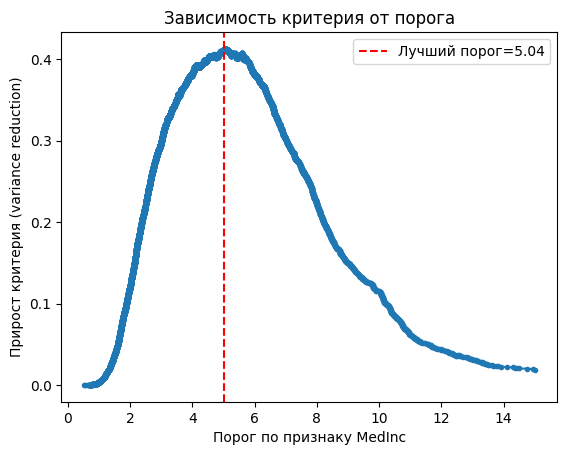

In [10]:
from sklearn.datasets import fetch_california_housing

feature_names = data.feature_names
idx = feature_names.index('MedInc')
thresholds, gains, best_thr, best_gain = find_best_split(X.iloc[:, idx], y, task="regression", feature_type="real")


import matplotlib.pyplot as plt
plt.plot(thresholds, gains, marker='.')
plt.xlabel('Порог по признаку MedInc')
plt.ylabel('Прирост критерия (variance reduction)')
plt.title('Зависимость критерия от порога')
plt.axvline(best_thr, color='red', linestyle='--', label=f'Лучший порог={best_thr:.2f}')
plt.legend()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

Лучший порог отмечен пунктиром -- 5.04

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции.
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в данных и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [11]:
class DecisionTree:
    # ... (инициализация)
    def _fit_node(self, sub_X, sub_y, node):
        # ... (условие останова как в коде)
        feature_best = None
        threshold_best = None
        gini_best = None
        split_mask = None

        for feature in range(sub_X.shape[1]):
            if self._feature_types[feature] == "real":
                feature_vector = sub_X[:, feature]
            else:  # categorical
                feature_vector = sub_X[:, feature]
            # Ищем лучший порог для этого признака
            _, _, thr, gain = find_best_split(feature_vector, sub_y, self.task, self._feature_types[feature])

            if gini_best is None or gain > gini_best:
                feature_best = feature
                gini_best = gain
                threshold_best = thr
                if self._feature_types[feature] == "real":
                    split_mask = (feature_vector <= thr)
                else:
                    split_mask = (feature_vector == thr)

        # Если не нашли хорошего разбиения, делаем лист
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        # Записываем разбиение в узел
        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        else:
            node["category_split"] = threshold_best
        node["left_child"], node["right_child"] = {}, {}

        # Рекурсивно строим левые и правые поддеревья
        self._fit_node(sub_X[split_mask], sub_y[split_mask], node["left_child"])
        self._fit_node(sub_X[~split_mask], sub_y[~split_mask], node["right_child"])

    def _predict_node(self, x, node):
        # Рекурсивный обход: если лист, возвращаем класс; иначе спускаемся по веткам
        if node["type"] == "terminal":
            return node["class"]
        feat = node["feature_split"]
        if self._feature_types[feat] == "real":
            if x[feat] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:  # categorical
            if x[feat] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])


In [12]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold  # вещественный признак
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold  # категориальный признак

                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        feature_idx = node["feature_split"]
        feature_val = x[feature_idx]

        if "threshold" in node:
            if feature_val <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif "category_split" in node:
            if feature_val == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Некорректная структура узла дерева")


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `STUDENTS` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [13]:
STUDENTS = 'https://www.dropbox.com/scl/fi/hnmqruw6px5wnm4bip2rz/students.csv?rlkey=ee113i30jnxid3sdxf4oipgkw&dl=1'

In [14]:
import pandas as pd
students = pd.read_csv(STUDENTS)
X = students.iloc[:, :5]
y = students.iloc[:, 5]
feature_names = X.columns

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

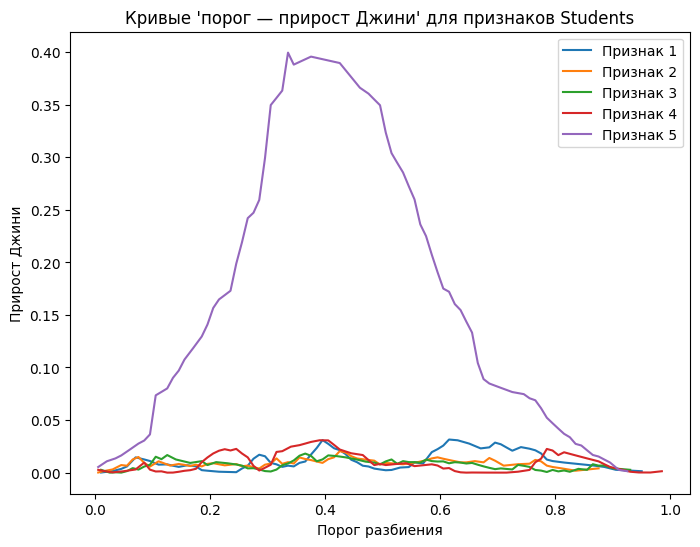

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(5):
    feat = X.iloc[:, i]
    thr, gains, best_thr, best_gain = find_best_split(feat, y, task="classification", feature_type="real")
    plt.plot(thr, gains, label=f"Признак {i+1}")
plt.xlabel("Порог разбиения")
plt.ylabel("Прирост Джини")
plt.legend()
plt.title("Кривые 'порог — прирост Джини' для признаков Students")
plt.show()

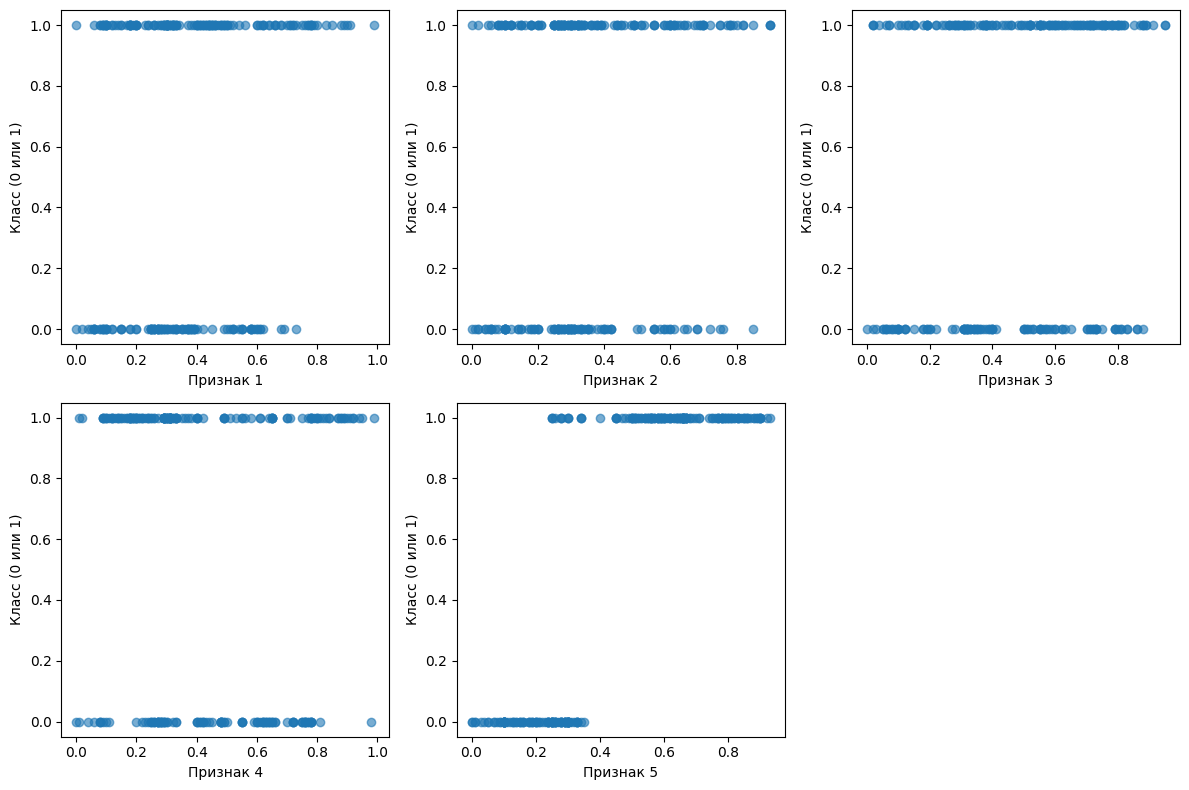

In [16]:
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.scatter(X.iloc[:, i], y, alpha=0.6)
    plt.xlabel(f"Признак {i+1}")
    plt.ylabel("Класс (0 или 1)")
plt.tight_layout()
plt.show()

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из датасета),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


column_names = ["class"] + [f"feature_{i}" for i in range(22)]
mushroom_df = pd.read_csv('agaricus-lepiota.data', header=None, names=column_names)
mushroom_df = mushroom_df.replace('?', np.nan).dropna()
for col in mushroom_df.columns:
    mushroom_df[col] = LabelEncoder().fit_transform(mushroom_df[col])


X = mushroom_df.drop("class", axis=1).values
y = mushroom_df["class"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)
feature_types = ["categorical"] * X_train.shape[1]
tree = DecisionTree(feature_types=feature_types, max_depth=5, min_samples_split=10, min_samples_leaf=5, task="classification")
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовой части (грибы): {accuracy:.4f}")

Accuracy на тестовой части (грибы): 1.0000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [19]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [20]:
DIABETES = 'diabetes.csv'

In [21]:
data = pd.read_csv(DIABETES)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

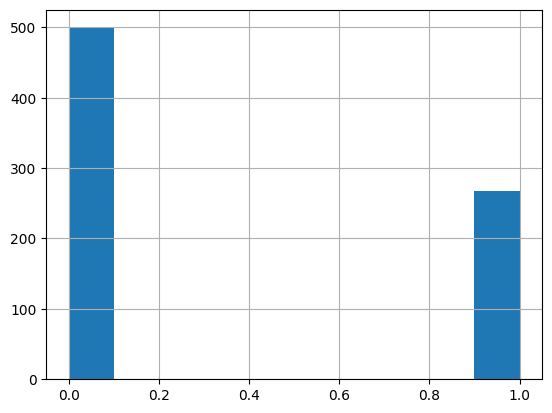

In [22]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [23]:
X = data.drop("Outcome", axis=1)
y = data["Outcome"]
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.30, random_state=42, stratify=y_train_all
)

print("Train-трейн:", X_train.shape, "Train-вал:", X_val.shape, "Test:", X_test.shape)

Train-трейн: (375, 8) Train-вал: (162, 8) Test: (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [24]:
from sklearn.metrics import f1_score

depth_list = [3, 5, 7, 9]
leaf_list = [1, 5, 10]

best_f1 = 0
best_params = None
for depth in depth_list:
    for leaf in leaf_list:
        clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaf, random_state=42)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_params = (depth, leaf)

print(f"Лучшие гиперпараметры: {best_params}, F1-val={best_f1:.4f}")

best_depth, best_leaf = best_params
final_tree = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_leaf, random_state=42)
final_tree.fit(X_train_all, y_train_all)
y_test_pred = final_tree.predict(X_test)

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
auc = roc_auc_score(y_test, final_tree.predict_proba(X_test)[:,1])

print(f"Тестовая оценка дерева: accuracy={acc:.3f}, precision={prec:.3f}, recall={rec:.3f}, AUC={auc:.3f}")

Лучшие гиперпараметры: (5, 1), F1-val=0.5455
Тестовая оценка дерева: accuracy=0.766, precision=0.800, recall=0.444, AUC=0.818


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [25]:
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=50, random_state=42
)
bag.fit(X_train_all, y_train_all)
y_bag_pred = bag.predict(X_test)

acc_bag = accuracy_score(y_test, y_bag_pred)
prec_bag = precision_score(y_test, y_bag_pred)
rec_bag = recall_score(y_test, y_bag_pred)
auc_bag = roc_auc_score(y_test, bag.predict_proba(X_test)[:,1])

print(f"Bagging (50 деревьев) - accuracy={acc_bag:.3f}, precision={prec_bag:.3f}, recall={rec_bag:.3f}, AUC={auc_bag:.3f}")

Bagging (50 деревьев) - accuracy=0.753, precision=0.688, recall=0.543, AUC=0.827


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [26]:
from sklearn.model_selection import cross_val_score

depth_list = [3, 5, 7, None]
split_list = [2, 5, 10]

best_score = 0
best_params_rf = None
for depth in depth_list:
    for min_split in split_list:
        rf = RandomForestClassifier(n_estimators=50, max_depth=depth,
                                    min_samples_split=min_split, random_state=42)
        scores = cross_val_score(rf, X_train_all, y_train_all, cv=5, scoring='f1')
        mean_f1 = scores.mean()
        if mean_f1 > best_score:
            best_score = mean_f1
            best_params_rf = (depth, min_split)

print(f"Лучшие параметры Random Forest: {best_params_rf}, F1_cv={best_score:.4f}")

best_depth, best_min_split = best_params_rf
rf_final = RandomForestClassifier(n_estimators=50, max_depth=best_depth,
                                  min_samples_split=best_min_split, random_state=42)
rf_final.fit(X_train_all, y_train_all)
y_rf_pred = rf_final.predict(X_test)

acc_rf = accuracy_score(y_test, y_rf_pred)
prec_rf = precision_score(y_test, y_rf_pred)
rec_rf = recall_score(y_test, y_rf_pred)
auc_rf = roc_auc_score(y_test, rf_final.predict_proba(X_test)[:,1])

print(f"Random Forest - accuracy={acc_rf:.3f}, precision={prec_rf:.3f}, recall={rec_rf:.3f}, AUC={auc_rf:.3f}")

Лучшие параметры Random Forest: (None, 10), F1_cv=0.6334
Random Forest - accuracy=0.740, precision=0.657, recall=0.543, AUC=0.821


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

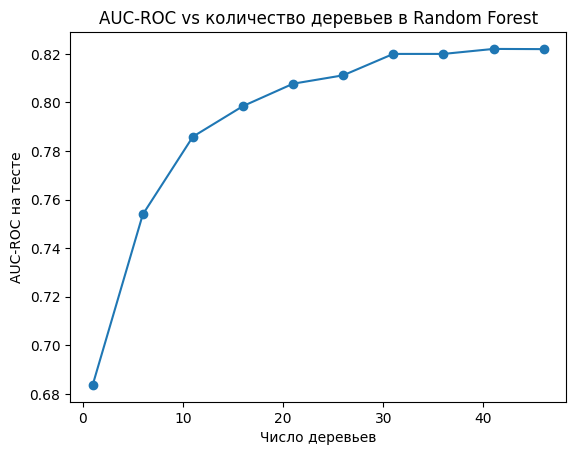

In [27]:
import matplotlib.pyplot as plt

n_estimators_list = range(1, 51, 5)
auc_scores = []
for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, max_depth=best_depth,
                                min_samples_split=best_min_split, random_state=42)
    rf.fit(X_train_all, y_train_all)
    y_prob = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    auc_scores.append(auc)

plt.plot(n_estimators_list, auc_scores, marker='o')
plt.xlabel("Число деревьев")
plt.ylabel("AUC-ROC на тесте")
plt.title("AUC-ROC vs количество деревьев в Random Forest")
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

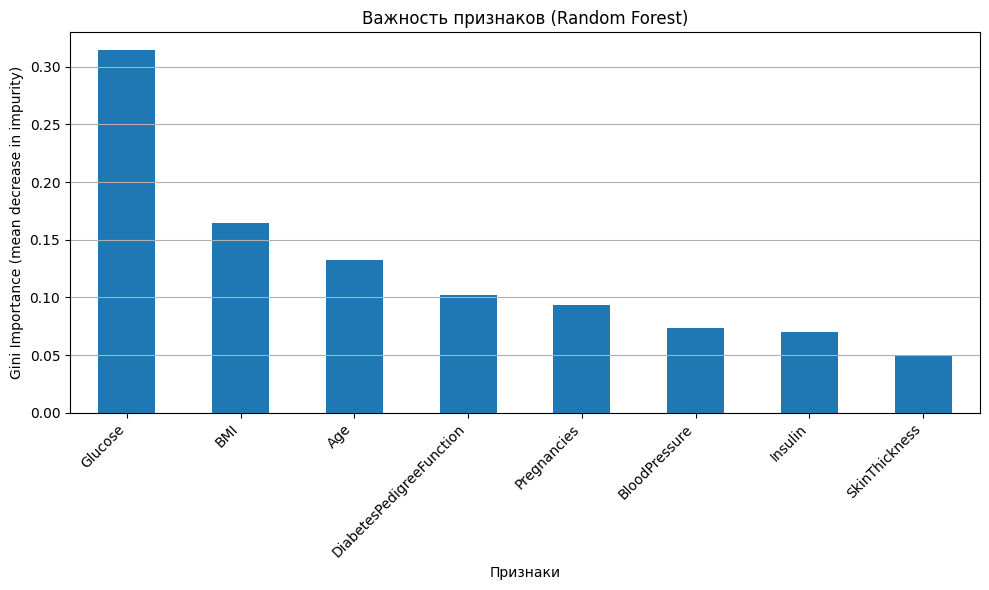


Самый важный признак: Glucose
Его важность: 0.3142


In [28]:
feature_names = X.columns
importances = rf_final.feature_importances_
feature_importance_series = pd.Series(importances, index=feature_names)
sorted_importances = feature_importance_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title("Важность признаков (Random Forest)")
plt.ylabel("Gini Importance (mean decrease in impurity)")
plt.xlabel("Признаки")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

most_important_feature = sorted_importances.index[0]
most_important_value = sorted_importances.iloc[0]
print(f"\nСамый важный признак: {most_important_feature}")
print(f"Его важность: {most_important_value:.4f}")

## Котобонус! (0.25 балла)

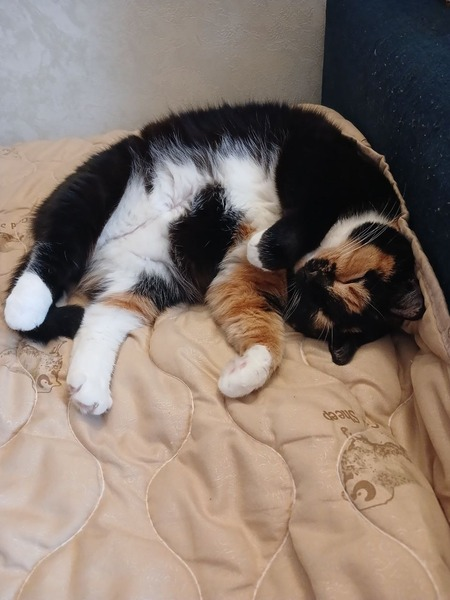

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?